In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib notebook
sns.set_style("darkgrid")

In [2]:
df = pd.read_csv('UKretail.csv', delimiter=',', encoding='ISO-8859-1')
df['total']=df['Quantity']*df['UnitPrice']
Nans = df[df.isnull().any(axis=1)]
df.dropna(how='any', inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'] = df['InvoiceDate'].dt.date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
#df['CustomerID'] = pd.Series(map(int, df['CustomerID']))
df.shape

(244154, 9)

<IPython.core.display.Javascript object>


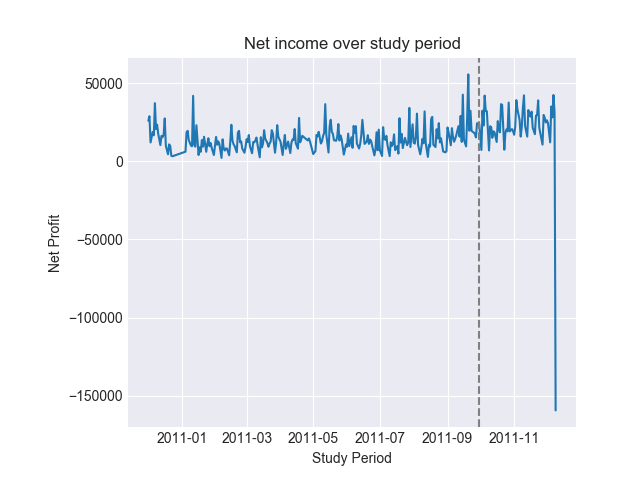

In [3]:
# Average Transaction per day
# We can additionally plot a vertical line to see how data is distributed between calibration and holdout period in 80-20 split
group_days = df.groupby('InvoiceDate')['total'].sum()
group_days
plt.figure()
plt.ylabel('Net Profit')
plt.xlabel('Study Period')
plt.plot(group_days.index, group_days)
plt.title('Net income over study period')
plt.subplots_adjust(left=.2)
plt.axvline(x=group_days.index[round(len(group_days)*0.8)], color='grey', linestyle='dashed')
# There is a big outlier towards the end of the period and it seems like wrong data input
# Apart from that, the split point is correct since there are not big differences in the trend of the plot

In [4]:
# There is a big return by customer 16446
bigreturn = df[df['InvoiceDate']=='2011-12-09']
bigreturn.loc[bigreturn['total'].idxmin()]

InvoiceNo                          C581484
StockCode                            23843
Description    PAPER CRAFT , LITTLE BIRDIE
Quantity                            -80995
InvoiceDate            2011-12-09 00:00:00
UnitPrice                             2.08
CustomerID                           16446
Country                     United Kingdom
total                              -168470
Name: 324262, dtype: object

In [6]:
# Let's see the rest of his transactions
cust16446 = df[df['CustomerID']==16446]
cust16446
# Probably it's a wrong data input

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total
116618,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18,1.65,16446.0,United Kingdom,1.65
116619,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18,1.25,16446.0,United Kingdom,1.25
324262,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09,2.08,16446.0,United Kingdom,-168469.60


In [419]:
no_returns = df[df['InvoiceNo'].apply(lambda x: x[0]!='C')]
invoices = no_returns.groupby(['CustomerID', 'InvoiceDate' ,'InvoiceNo']).agg({'total':sum})
invoices.reset_index(inplace=True)

<IPython.core.display.Javascript object>


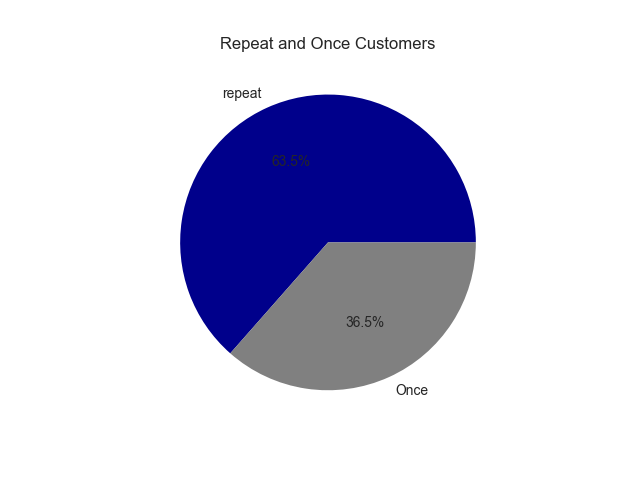

([<matplotlib.patches.Wedge at 0x135f9470>,
 [<matplotlib.text.Text at 0x135f93d0>, <matplotlib.text.Text at 0x1c9a0a90>],
 [<matplotlib.text.Text at 0x1c9a00f0>, <matplotlib.text.Text at 0x1c9a0310>])

In [421]:
# We need to find the different transactions per customer. By different, we mean that they occured in different dates
transactions = invoices.groupby('CustomerID').InvoiceDate.nunique()
# Let's plot a pie with the number of repeat and once customers.
repeat = len(transactions[transactions>=2])
non_repeat = len(transactions[transactions==1])
plt.figure()
plt.axis('equal')
plt.title('Repeat and Once Customers')
plt.pie(x=[repeat,non_repeat], labels=['repeat', 'Once'], autopct='%1.1f%%', colors=['darkblue','grey'])

<IPython.core.display.Javascript object>


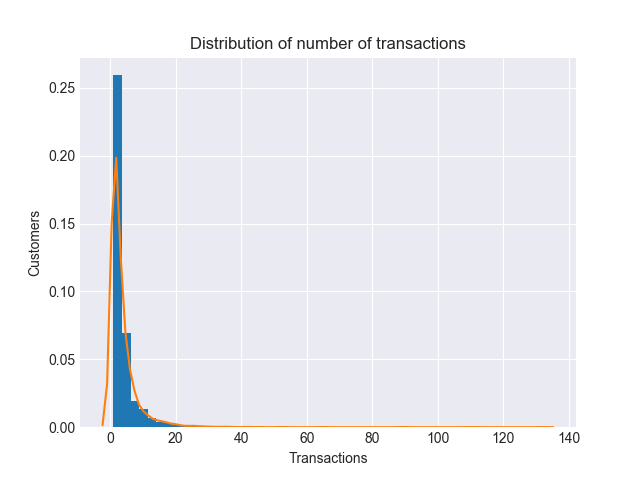

In [441]:
# Plot the frequency of number of transactions in a histogram. We see a very steep gamma distribution because of the customers
# who boght only once
plt.figure()
plt.hist(transactions.values, bins=50, normed=True)
plt.title('Distribution of number of transactions')
plt.xlabel('Transactions')
plt.ylabel('Customers')
sns.kdeplot(transactions.values)

<IPython.core.display.Javascript object>


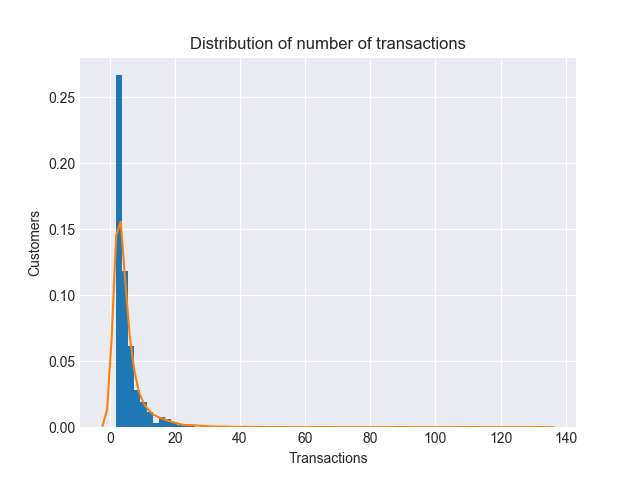

In [493]:
# From the above diagram, we exclude the one-timers and plot the repeat customers
repeat_customers = transactions[transactions>1]
plt.figure()
plt.hist(repeat_customers.values, bins=70, normed=True)
plt.title('Distribution of number of transactions')
plt.xlabel('Transactions')
plt.ylabel('Customers')
sns.kdeplot(repeat_customers.values)

<IPython.core.display.Javascript object>


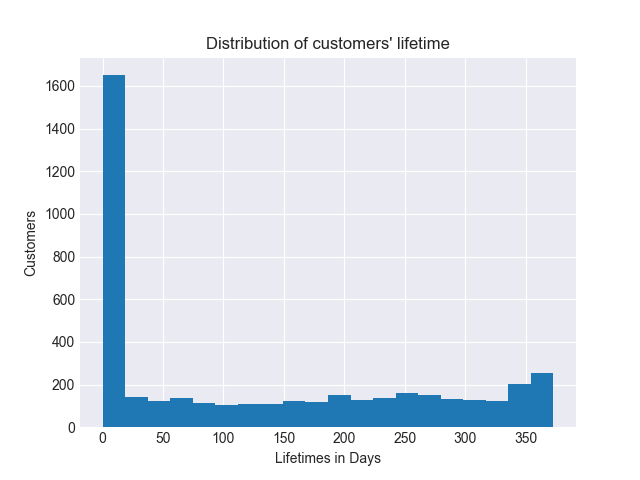

(array([ 1650.,   140.,   125.,   137.,   114.,   105.,   110.,   111.,
          122.,   116.,   153.,   129.,   135.,   161.,   149.,   130.,
          129.,   122.,   201.,   252.]),
 array([   0.  ,   18.65,   37.3 ,   55.95,   74.6 ,   93.25,  111.9 ,
         130.55,  149.2 ,  167.85,  186.5 ,  205.15,  223.8 ,  242.45,
         261.1 ,  279.75,  298.4 ,  317.05,  335.7 ,  354.35,  373.  ]),
 <a list of 20 Patch objects>)

In [500]:
# For each customer plot his lifetime. The date of his last transaction - the day of his first transaction
# Apart from the low frequencies, the company keeps a good hold on their customers
customer_lifetime = invoices.groupby('CustomerID').agg({'InvoiceDate':[min,max]})
customer_lifetime.columns = customer_lifetime.columns.droplevel(0)
customer_lifetime['lifetime'] = pd.to_datetime(customer_lifetime['max']).dt.date-pd.to_datetime(customer_lifetime['min']).dt.date
customer_lifetime['lifetime'] =customer_lifetime['lifetime'].dt.days
plt.figure()
plt.title('Distribution of customers\' lifetime')
plt.xlabel('Lifetimes in Days')
plt.ylabel('Customers')
plt.hist(customer_lifetime['lifetime'].values, bins=20)